# Mushroom Classification Project

## Notes

Link to the dataset: https://www.kaggle.com/uciml/mushroom-classification
- Mushroom toxicity links: https://www.thenakedscientists.com/articles/interviews/why-are-mushrooms-poisonous
    -  There's a huge number of mushroom toxins that all act in very, very different ways that aren't even related to each other.
    - https://www.wildfooduk.com/articles/how-to-tell-the-difference-between-poisonous-and-edible-mushrooms/
    - some rules: "Avoid mushrooms with white gills, a skirt or ring on the stem and a bulbous or sack like base called a volva" and "Avoid mushrooms with red on the cap or stem"
- The two types of mushrooms that are included in this dataset
    - Agaricus: https://en.wikipedia.org/wiki/Agaricus
    - Lepoita: https://en.wikipedia.org/wiki/Lepiota

### Imports

In [1]:
import pandas as pd
from scipy.stats import chi2_contingency, chi2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
from xgboost import plot_importance
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 300)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, train_test_split
from functions import *

In [2]:
df = pd.read_csv("mushrooms.csv")

### Removing unwanted columns
This is done to make the project slightly more challenging and more intuitive to a layman using this model and easier to take measurements

In [3]:
unwanted_columns = ['spore-print-color', 'stalk-surface-above-ring', 'stalk-surface-below-ring','stalk-shape', 
                    'stalk-root', "gill-size", 'odor',"gill-attachment"] 
df.drop(columns = unwanted_columns, inplace=True)

# EDA

### Class imbalance for target variable?

In [4]:
df.columns

Index(['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises',
       'gill-spacing', 'gill-color', 'stalk-color-above-ring',
       'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
       'ring-type', 'population', 'habitat'],
      dtype='object')

In [5]:
# no large class imbalance
df['class'].value_counts()

e    4208
p    3916
Name: class, dtype: int64

### What values are in each column?

In [6]:
col_unique_dict = {}
for item in df.columns:
    col_unique_dict[item] = list(df[item].unique())

In [7]:
# most columns refer to colors (e.g.: veil color has "white", "none", "orange", "yellow")
col_unique_dict

{'class': ['p', 'e'],
 'cap-shape': ['x', 'b', 's', 'f', 'k', 'c'],
 'cap-surface': ['s', 'y', 'f', 'g'],
 'cap-color': ['n', 'y', 'w', 'g', 'e', 'p', 'b', 'u', 'c', 'r'],
 'bruises': ['t', 'f'],
 'gill-spacing': ['c', 'w'],
 'gill-color': ['k', 'n', 'g', 'p', 'w', 'h', 'u', 'e', 'b', 'r', 'y', 'o'],
 'stalk-color-above-ring': ['w', 'g', 'p', 'n', 'b', 'e', 'o', 'c', 'y'],
 'stalk-color-below-ring': ['w', 'p', 'g', 'b', 'n', 'e', 'y', 'o', 'c'],
 'veil-type': ['p'],
 'veil-color': ['w', 'n', 'o', 'y'],
 'ring-number': ['o', 't', 'n'],
 'ring-type': ['p', 'e', 'l', 'f', 'n'],
 'population': ['s', 'n', 'a', 'v', 'y', 'c'],
 'habitat': ['u', 'g', 'm', 'd', 'p', 'w', 'l']}

In [8]:
df['veil-type'].nunique()

1

#### Dropping veil_type

In [9]:
df.drop(columns = ['veil-type'], inplace = True)

### Broad categories of columns

- The broad categories of the remaining columns are:
    - spore
    - cap 
    - stalk
    - gills 
    - veil 
    - ring

### Checking how many nans there are in the dataset

In [10]:
nan_count_list = []
for item in df.columns:
    nan_count = df[item].isnull().sum()
    nan_count_list.append(f"{item} has {nan_count} nan values")

In [11]:
# no nans left in the dataset 
nan_count_list

['class has 0 nan values',
 'cap-shape has 0 nan values',
 'cap-surface has 0 nan values',
 'cap-color has 0 nan values',
 'bruises has 0 nan values',
 'gill-spacing has 0 nan values',
 'gill-color has 0 nan values',
 'stalk-color-above-ring has 0 nan values',
 'stalk-color-below-ring has 0 nan values',
 'veil-color has 0 nan values',
 'ring-number has 0 nan values',
 'ring-type has 0 nan values',
 'population has 0 nan values',
 'habitat has 0 nan values']

### Datatypes and describing data

In [12]:
df.dtypes

class                     object
cap-shape                 object
cap-surface               object
cap-color                 object
bruises                   object
gill-spacing              object
gill-color                object
stalk-color-above-ring    object
stalk-color-below-ring    object
veil-color                object
ring-number               object
ring-type                 object
population                object
habitat                   object
dtype: object

In [13]:
df.describe()

,class,cap-shape,cap-surface,cap-color,bruises,gill-spacing,gill-color,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,2,12,9,9,4,3,5,6,7
top,e,x,y,n,f,c,b,w,w,w,o,p,v,d
freq,4208,3656,3244,2284,4748,6812,1728,4464,4384,7924,7488,3968,4040,3148


### Examining Features

#### Visualizing the features

##### Stacked bar charts

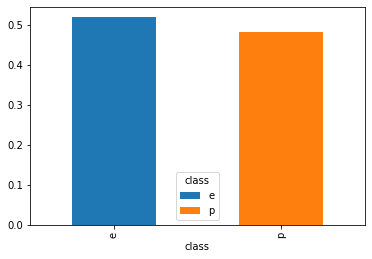

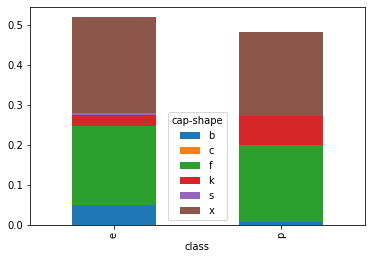

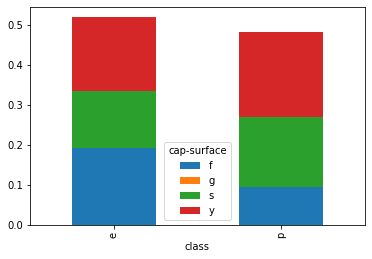

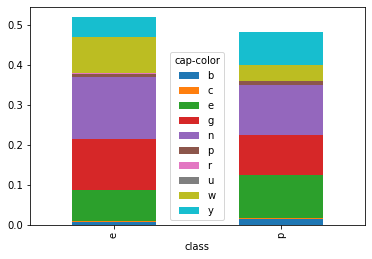

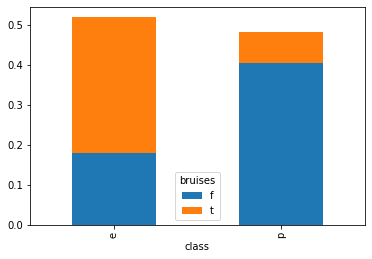

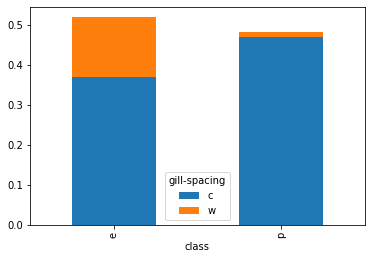

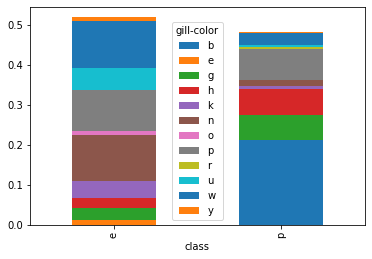

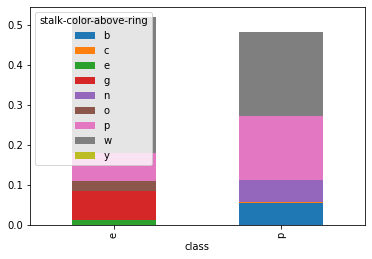

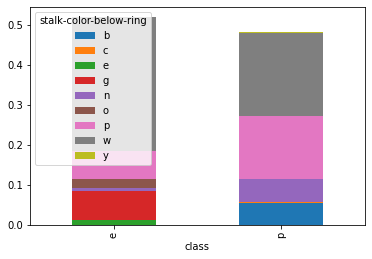

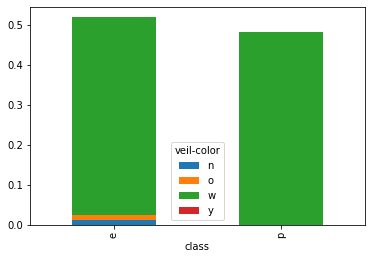

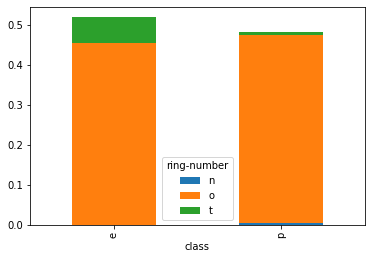

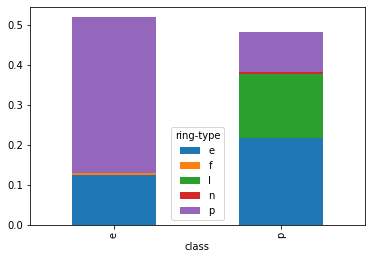

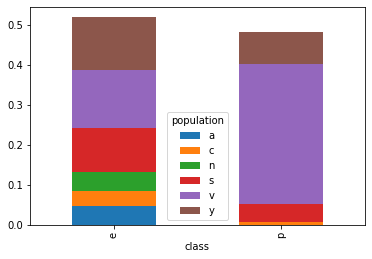

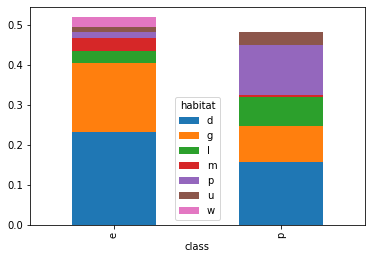

In [14]:
for item in df.columns:
    pd.crosstab(index = df['class'], columns = df[item], normalize = True).plot(kind='bar', stacked=True)
    plt.show()

### Train / Test / Split 

#### Split with dummies for each

In [15]:
dummy_df = pd.get_dummies(data=df, drop_first = True)

In [16]:
X_dum = dummy_df.drop('class_p', axis = 1)
y_dum = dummy_df['class_p']

In [17]:
X_dum_train, X_dum_test, y_dum_train, y_dum_test = train_test_split(X_dum, y_dum, random_state=1)

#### Using Chi-Squared Test to Find predictive value of feature values 

In [18]:
all_column_chi = get_chi_values(y_dum_train, X_dum_train)
independent_cols = [key for key, values in all_column_chi.items() if values[1] == 'Independent (fail to reject H0)']
dependent_cols = [key for key, values in all_column_chi.items() if values[1] == 'Dependent (reject H0)']

In [19]:
# most columns are dependent of the classes edible or poisnous, meaning that they will improve predictions
print(f"The number of feature values that are dependent is {len(dependent_cols)}")
print(f"The number of feature values that are independent is {len(independent_cols)}")

The number of feature values that are dependent is 63
The number of feature values that are independent is 3


# Model Selection

### Logistic Regression

#### Viewing ROC plot for all of the best features 

In [25]:
def only_best_features2(dummy_df = dummy_df):
    X_dum = dummy_df.drop('class_p', axis = 1)
    y_dum = dummy_df['class_p']
    X_dum_train, X_dum_test, y_dum_train, y_dum_test = train_test_split(X_dum, y_dum, random_state=1)
    logreg = LogisticRegression(max_iter=100, random_state = 5, verbose = 0, penalty='l1', solver = 'saga')
    for i in range(0, len(X_dum_train.columns)):
        column = X_dum_train.columns[i]
        logreg.fit(X_dum_train[[column]], y_dum_train)
        dum_predict_log = logreg.predict(X_dum_test[[column]])
        fpr, tpr, thresholds = metrics.roc_curve(y_dum_test, dum_predict_log)
        plt.plot(fpr, tpr, label= f"{column}")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.title('ROC curve for Mushrooms Classification')
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
#         plt.legend()
        plt.grid(True)

/Users/gregfeliu/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gregfeliu/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gregfeliu/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gregfeliu/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gregfeliu/opt/anaconda3/envs/learn-env/lib/py

/Users/gregfeliu/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gregfeliu/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gregfeliu/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gregfeliu/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gregfeliu/opt/anaconda3/envs/learn-env/lib/py

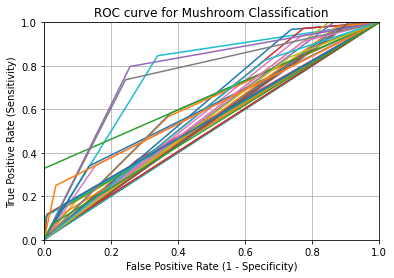

In [20]:
num_of_improving_features = only_improving_features(X_dum, y_dum)

In [21]:
print(f"The total number of (dummy) features is: {X_dum_train.shape[1]}")
print(f"The number of (dummy) features that improve logistic regression predictability is: \
{num_of_improving_features}")      
print(f"{X_dum_train.shape[1] - num_of_improving_features} features do not improve logistic \
regression predictability")

The total number of (dummy) features is: 66
The number of (dummy) features that improve logistic regression predictability is: 43
23 features do not improve logistic regression predictability


#### Viewing ROC plot for the all features 

In [58]:
#use l2 penalty b/c that works better when there arent any outliers
logreg = LogisticRegression(C=10, max_iter=50, random_state = 5, penalty='l1', solver='liblinear')
logreg.fit(X_dum_train, y_dum_train)
log_reg_predictions = logreg.predict(X_dum_test)

In [59]:
cm = metrics.confusion_matrix(y_dum_test, log_reg_predictions)
print(cm)

[[1000   20]
 [  16  995]]


In [148]:
logreg_recall = recall_score(y_dum_test, log_reg_predictions)
print(logreg_recall)

0.9841740850642928


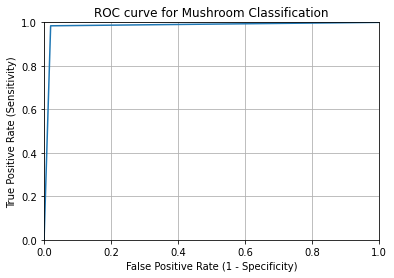

In [63]:
print_roc_curve(y_dum_test, dum_predict_logreg)

### XGBoost

#### GridSearch1

In [69]:
# starting with wide parameter distribution
xgb_classifier = xgb.XGBClassifier(objective = 'binary:logistic')
param_dist = {'n_estimators': list(range(0, 400, 50)),
              'learning_rate': [0.21, 0.31, 0.41, 0.51, 0.61],
              'max_depth': [3],
              'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7],
              'min_child_weight': [1]
             }

In [70]:
#initiate the Gridsearch model
gsearch1 = GridSearchCV(
    estimator = xgb_classifier,
    param_grid = param_dist, 
    scoring='recall',
    n_jobs=-1,
    verbose=0,
    iid=False, 
    cv=3)

In [71]:
xgb_model1 = gsearch1.fit(X_dum_train,y_dum_train)

In [72]:
gsearch1.best_params_

{'colsample_bytree': 0.3,
 'learning_rate': 0.41,
 'max_depth': 3,
 'min_child_weight': 1,
 'n_estimators': 100}

In [73]:
gsearch1.best_score_

0.9948371983272067

#### GridSearch2

- The best parameters from the first gridsearch
    - {'colsample_bytree': 0.3,
 'learning_rate': 0.41,
 'max_depth': 3,
 'min_child_weight': 1,
 'n_estimators': 100}

In [74]:
# narrower parameter distribution
xgb_classifier2 = xgb.XGBClassifier(objective = 'binary:logistic')
param_dist2 = {'n_estimators': [75, 100, 125],
              'learning_rate': [0.39, 0.41, 0.43],
              'max_depth': [3],
              'colsample_bytree': [0.25, 0.3, 0.35],
              'min_child_weight': [1]
             }

In [75]:
gsearch2 = GridSearchCV(
    estimator = xgb_classifier2,
    param_grid = param_dist2, 
    scoring='recall',
    n_jobs=-1,
    verbose=0,
    iid=True, 
    cv=3)

In [76]:
xgb_model2 = gsearch2.fit(X_dum_train,y_dum_train)

In [77]:
gsearch2.best_params_

{'colsample_bytree': 0.3,
 'learning_rate': 0.41,
 'max_depth': 3,
 'min_child_weight': 1,
 'n_estimators': 100}

In [78]:
gsearch2.best_score_

0.9948366909070848

#### Fitting xgb model 

In [102]:
xgb_clf_final = xgb.XGBClassifier(objective ='binary:logistic', 
                           colsample_bytree = 0.4, 
                           learning_rate = 0.51,
                           max_depth = 4, 
                           n_estimators = 200)

In [103]:
xgb_clf_final_fit = xgb_clf_final.fit(X_dum_train,y_dum_train)

In [104]:
xgb_clf_final_predictions = xgb_clf_final_fit.predict(X_dum_test)
xgb_clf_final_precision = precision_score(y_dum_test, xgb_clf_final_predictions)
xgb_clf_final_recall = recall_score(y_dum_test, xgb_clf_final_predictions)
xgb_clf_final_recall

0.9970326409495549

In [105]:
xgb_cm = metrics.confusion_matrix(y_dum_test, xgb_clf_final_predictions)
print(xgb_cm)

[[1013    7]
 [   3 1008]]


##### Plotting Feature Importance

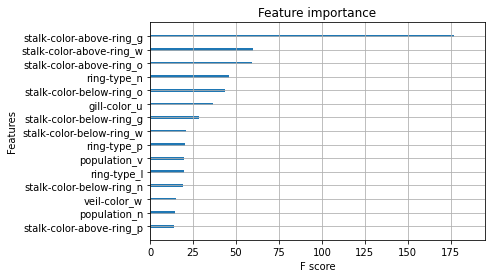

In [107]:
plot_importance(xgb_clf_final_fit, max_num_features=15, importance_type = 'gain', show_values=False)
# plt.savefig("XGBoost_feature_importance.png", optimize = True, pad_inches = 0.2, bbox_inches = 'tight')

In [113]:
xgb_col_importances = xgb_clf_final.get_booster().get_score(importance_type = 'gain')

In [115]:
xgb_sorted_by_column_importance = sorted(xgb_col_importances.items(), key=lambda x: x[1], reverse=True)
xgb_sorted_by_column_importance[0:5]

[('stalk-color-above-ring_g', 177.16729857500002),
 ('stalk-color-above-ring_w', 59.908161794729985),
 ('stalk-color-above-ring_o', 59.065714568249994),
 ('ring-type_n', 46.18153),
 ('stalk-color-below-ring_o', 43.3846436)]

### Random Forest Classifier

In [116]:
rf = RandomForestClassifier(n_estimators = 10000, random_state = 42)
rf_fitted = rf.fit(X_dum_train, y_dum_train)
rf_pred = rf_fitted.predict(X_dum_test)

In [149]:
rf_recall = recall_score(y_dum_test, rf_pred)
print(rf_recall)

0.9970326409495549


In [118]:
random_forest_cm = metrics.confusion_matrix(y_dum_test, rf_pred)
print(random_forest_cm)

[[1013    7]
 [   3 1008]]


# Model Evaluation

The important measure in this project is recall since we want to absolutely sure that the mushroom predicted to be edible is in fact edible

## Model Scores 

In [150]:
print(f"The best Logistic Regression recall score is: {logreg_recall}")
print(f"The best XGBoost recall score is: {xgb_clf_final_recall}")
print(f"The best Random Forest recall score is: {rf_recall}")

The best Logistic Regression recall score is: 0.9841740850642928
The best XGBoost recall score is: 0.9970326409495549
The best Random Forest recall score is: 0.9970326409495549


## Are the XGBoost and Random Forest Predictions the same

In [151]:
# did they all miss the same instances? Yes
np.array_equal(xgb_clf_final_predictions, rf_pred)

True

# Conclusions 

This data set presented easily viewable characteristics of a (hypothetical) sample of mushrooms in the Agaricus and Lepoita families. Using an XGBoost model and a Random Forest model, I am able to determine with 99.7% accuracy whether a mushroom is poisonous. Since both models mispredicted the same 3 mushroom samples, it's possible that these were mislabelled in some capacity. According to the XGBoost model, the most important feature is a green stalk color above the ring. Similarly, the next two most important features involved the stalk color above the ring (being 2: white or 3: orange). 